# The dataset used in this notebook is not a real dataset. It was created with an algorithm and does not represent actual student data.

This Jupyter Notebook presents an analysis of a fictional educational dataset including the following data: ID, Gender, Race, Grade, Attendance Rate, Free or Reduced Lunch, Primary Language, Lives with Parent/Guardian, Promoted, SEL Score, Reading Level, Case Managed, and Average Grade. While the data isn't real, and there could be many more variables to factor into a real predictive model for student-level education outcomes, this project is being used with the goal of creating a basic predictive model to determine which of the included variables are significant in predicting if a given student was promoted or retained. This dataset consists of 657 observations across 14 columns/variables and includes both continuous and categorical variables.

This notebook begins with the loading and cleaning of the data before moving into some basic exploratory analysis which includes descriptive statistics for the continuous variables and counts for the categorical. Visualizations are used to explore distribution and frequency of some variables. In preparation for deeper analysis, the categorical variables are encoded using one-hot encoding, and a correlation matrix is included to take a cursory look at significant relationships between the included variables.

Before the predictive model is created, the data is first split into training (70%) and testing (30%) sets. A decision tree model is then created using the training data followed by evaluation by the testing data using the following metrics: accuracy, precision, recall, and the F1 score.

The model identified whether a student was case managed, their attendance rate, whether or not they were at-risk of dropping out, and identifying as male as being the most important variables in predicting promotion to the next grade. In turn, these variables could be helpful moving forward in identifying students who are at risk of not being promoted to the next grade. This model could provide insights for identifying both students who are likely to be promoted as well as students who are at risk of retention based on a combination of variables. In turn, it could be leveraged to identify (with further work) what supports students might need to increase their probability for promotion. Finally, this model could likely be improved by incorporating additional variables, more observations, or using more advanced machine learning techniques.

Throughout the notebook, there are comments to provide explanations for each step.  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.stats as stats

In [2]:
# Load the dataset.
FileName = 'fake_ed_data.csv'
edu = pd.read_csv('fake_ed_data.csv')

In [3]:
# Display first 5 rows of the dataset to get an idea of the data
edu.head()

,Student ID,Gender,Race,Current Grade Level,Attendance Rate,At-risk of Dropping Out,Free-Reduced Lunch,Primary Language Spoken in the Home,Lives with Parent/Guardian,Promotion to Next Grade,SEL Rating,Reading Level,Receiving Case Management,Average Grade Percentage
0,1,Male,White,1st Grade,95%,No,Yes,English,Yes,Promoted,4.0,Below Grade,No,85
1,2,Female,Black,2nd Grade,85%,Yes,Yes,English,No,Promoted,2.0,On Grade,Yes,72
2,3,Male,Hispanic,3rd Grade,90%,No,Yes,Spanish,Yes,Promoted,3.0,Above Grade,No,80
3,4,Female,Asian,4th Grade,92%,No,No,English,Yes,Promoted,5.0,On Grade,Yes,90
4,5,Male,Native American,5th Grade,80%,Yes,Yes,English,No,Retained,2.0,Below Grade,Yes,68


In [4]:
# Check if there are missing values that should be dealt with before cleaning or running any analysis
edu.isnull().sum()

Student ID                             0
Gender                                 0
Race                                   0
Current Grade Level                    0
Attendance Rate                        0
At-risk of Dropping Out                0
Free-Reduced Lunch                     0
Primary Language Spoken in the Home    0
Lives with Parent/Guardian             0
Promotion to Next Grade                0
SEL Rating                             0
Reading Level                          0
Receiving Case Management              0
Average Grade Percentage               0
dtype: int64

We can see above that there are no missing values for any of the variables.

In [5]:
# Rename columns so they are easier to work with.
edu = edu.rename(columns={
    'Student ID': 'ID',
    'Current Grade Level': 'Grade',
    'Attendance Rate': 'Attendance_rate',
    'At-risk of Dropping Out': 'At_risk',
    'Free-Reduced Lunch': 'Free_reduced_lunch', 
    'Primary Language Spoken in the Home': 'Primary_lang',
    'Lives with Parent/Guardian': 'Lives_with_parent_guardian', 
    'Promotion to Next Grade': 'Promoted',
    'SEL Rating':'SEL_score',
    'Reading Level':'Reading_level', 
    'Receiving Case Management':'Case_managed',
    'Average Grade Percentage':'Average_grade'
})

# Replace values in columns to be in a consistent format.
replace_dict = {
    '8th': '8th Grade',
    '7th': '7th Grade',
    ' Promoted': 'Promoted',
    'Not Promoted': 'Retained',
    'Caucasian' : 'White',
    'Caucasian American': 'White'
}
edu = edu.replace(replace_dict)

In [6]:
# Strip leading/trailing whitespaces.
edu = edu.apply(lambda x: x.str.strip() if x.dtype == 'object' else x)

# Convert columns to float and remove the "%" sign from those columns for easier use later.
float_columns = ['Attendance_rate', 'Average_grade']
for column in float_columns:
    edu[column] = edu[column].str.replace('%', '').astype(float)
    
# Change columns with "yes" and "no" values to 1 and 0 respectively so they are more easily utilized in analysis.
edu.replace({'At_risk': {'Yes': 1, 'No': 0},
             'Free_reduced_lunch': {'Yes': 1, 'No': 0},
             'Lives_with_parent_guardian': {'Yes': 1, 'No': 0},
             'Case_managed': {'Yes': 1, 'No': 0},
             'Promoted': {'Promoted': 1, 'Retained': 0}}, inplace=True)

In [7]:
# Export the cleaned data to an Excel file for use in visualizing the data in a program like Tableau.
edu.to_excel("fake_ed_data.xlsx") 

In [8]:
# One approach to descriptive statistics it to calculate them only for the continuous variables.
print("Descriptive statistics for:\n", edu[['Attendance_rate', 'SEL_score', 'Average_grade']].describe())

Descriptive statistics for:
        Attendance_rate   SEL_score  Average_grade
count       657.000000  657.000000     657.000000
mean         88.140030    3.189498      82.150685
std           6.813401    0.745144       7.367745
min          65.000000    2.000000      58.000000
25%          85.000000    2.800000      77.000000
50%          89.000000    3.300000      85.000000
75%          93.000000    3.800000      88.000000
max         100.000000    5.000000      96.000000


In [9]:
# Another approach is to pull them for the entire dataset and keep in mind that for categorical variables, statistics like
# mean and standard deviation (among others) are not useful.

edu.describe()

,ID,Attendance_rate,At_risk,Free_reduced_lunch,Lives_with_parent_guardian,Promoted,SEL_score,Case_managed,Average_grade
count,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000
mean,743.264840,88.140030,0.277017,0.943683,0.986301,0.847793,3.189498,0.741248,82.150685
std,552.676098,6.813401,0.447866,0.230708,0.116325,0.359495,0.745144,0.438283,7.367745
min,1.000000,65.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,58.000000
25%,166.000000,85.000000,0.000000,1.000000,1.000000,1.000000,2.800000,0.000000,77.000000
50%,1032.000000,89.000000,0.000000,1.000000,1.000000,1.000000,3.300000,1.000000,85.000000
75%,1296.000000,93.000000,1.000000,1.000000,1.000000,1.000000,3.800000,1.000000,88.000000
max,1420.000000,100.000000,1.000000,1.000000,1.000000,1.000000,5.000000,1.000000,96.000000


From these descriptive statistics, it is apparent that there are 657 rows/observations for each variable included. The mean values indicate that for this data set, students attend school an average of 88% of the days with a standard deviation of nearly 7 days, have an average SEL score of 3.2 on a scale of 1 (low) to 5 (high) with a standard deviation of 0.75, and the average of their grades is around 82.2% with a standard deviation of about 7%. The standard deviations are relatively small for each variable, and this indicates that the means are generally representative of the sample present in the data set.

It is also worth noting that some of the variables in this dataset are binary, taking on values of either 0 or 1. At_risk denotes whether a student is identified as at-risk of dropping out (1) or not (0), Free_reduced_lunch indicates whether the student receives free or reduced lunch(1), Lives_with_parent_guardian tells us whether the student lives with their parent or a guardian (1), and Promoted shows whether the student was promoted to the next grade (1) or retained.

Overall, these descriptive statistics provide an initial understanding of the distribution of values in the dataset and can serve as a basis for further exploration and analysis.

In [10]:
# Counts for each category of the categorical variables 
cat_vars = ['Gender', 'Race', 'Grade', 'Primary_lang', 'Reading_level']
for var in cat_vars:
    print(f"\n{var}:\n", edu[var].value_counts(normalize=True))


Gender:
 Male      0.500761
Female    0.499239
Name: Gender, dtype: float64

Race:
 White               0.493151
Hispanic            0.193303
Black               0.140030
Asian               0.117199
African American    0.053272
Native American     0.003044
Name: Race, dtype: float64

Grade:
 10th Grade    0.144597
12th Grade    0.144597
9th Grade     0.143075
11th Grade    0.143075
7th Grade     0.086758
8th Grade     0.080670
6th Grade     0.066971
1st Grade     0.039574
2nd Grade     0.038052
3rd Grade     0.038052
5th Grade     0.038052
4th Grade     0.036530
Name: Grade, dtype: float64

Primary_lang:
 English    0.82344
Spanish    0.17656
Name: Primary_lang, dtype: float64

Reading_level:
 On Grade       0.412481
Below Grade    0.324201
Above Grade    0.263318
Name: Reading_level, dtype: float64


These stats demonstrate that the gender data is roughly 50/50 male/female, and the breakdown of students between 9th, 10th, 11th, and 12th grade are very similar with a smaller proportion of students in the other grade levels. Caucasian is the most common racial identity by a large margin, and English is spoken much more frequently at home compared to Spanish. Reading levels are fairly spread out between on grade level (the most common), below grade level, and above grade level. 

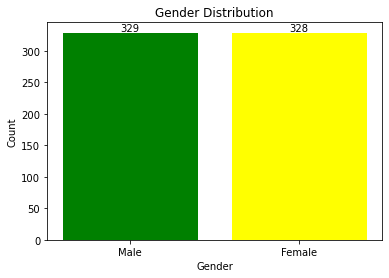

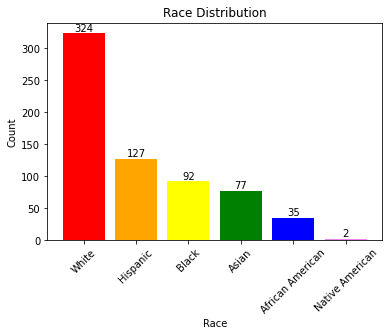

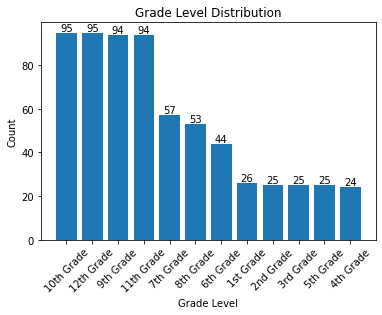

In [11]:
# Create some plots to get an idea of frequencies of some variables across the dataset

# create bar chart for Gender
gender_counts = edu['Gender'].value_counts()
colors = ['green', 'yellow']
plt.bar(gender_counts.index, gender_counts.values, color=colors)
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
for i, count in enumerate(gender_counts.values):
    plt.text(i, count, str(count), ha='center', va='bottom')
plt.show()

# create bar chart for Race
race_counts = edu['Race'].value_counts()
colors2 = ['red', 'orange', 'yellow', 'green', 'blue', 'violet', 'pink', 'black']
plt.bar(race_counts.index, race_counts.values, color=colors2)
plt.title('Race Distribution')
plt.xlabel('Race')
plt.ylabel('Count')
for i, count in enumerate(race_counts.values):
    plt.text(i, count, str(count), ha='center', va='bottom')
plt.xticks(rotation=45)
plt.show()

#create bar chart for Grade Level
grade_counts = edu['Grade'].value_counts()
plt.bar(grade_counts.index, grade_counts.values)
plt.title('Grade Level Distribution')
plt.xlabel('Grade Level')
plt.ylabel('Count')
for i, count in enumerate(grade_counts.values):
    plt.text(i, count, str(count), ha='center', va='bottom')
plt.xticks(rotation=45)
plt.show()

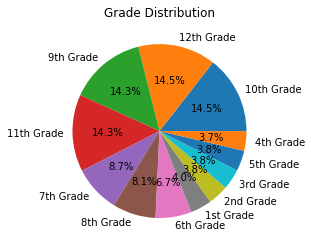

In [12]:
# create pie chart for Grade
grade_counts = edu['Grade'].value_counts()
plt.pie(grade_counts.values, labels=grade_counts.index, autopct='%1.1f%%')
plt.title('Grade Distribution')
plt.show()

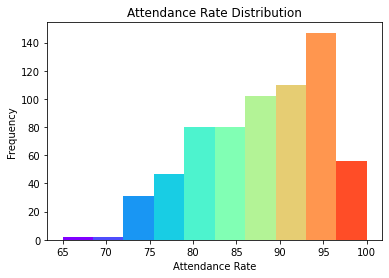

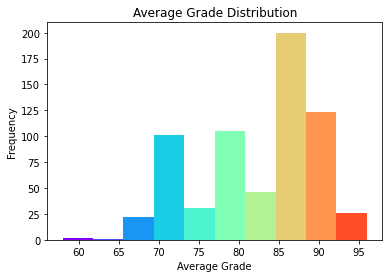

In [13]:
# create histogram for Attendance_rate
cmap = plt.cm.get_cmap('rainbow')
counts, _, _ = plt.hist(edu['Attendance_rate'], bins=10)
for i, patch in enumerate(plt.gca().patches):
    color = cmap(i / len(counts))
    patch.set_facecolor(color)
plt.xlabel('Attendance Rate')
plt.ylabel('Frequency')
plt.title('Attendance Rate Distribution')
plt.show()

# create a histogram of average grade with rainbow colors
cmap = plt.cm.get_cmap('rainbow')
counts, _, _ = plt.hist(edu['Average_grade'], bins=10)
for i, patch in enumerate(plt.gca().patches):
    color = cmap(i / len(counts))
    patch.set_facecolor(color)
plt.xlabel('Average Grade')
plt.ylabel('Frequency')
plt.title('Average Grade Distribution')
plt.show()

In [14]:
# More data prep before getting into in-depth analysis and building a predictive model
# Starting with using an encoding method to prepare the categorical columns

cat_cols = ['Gender', 'Race', 'Grade', 'Primary_lang', 'Reading_level']

edu_reg_ready = edu.copy()
for col in cat_cols:
    if col in edu.columns:
        encoded_cols = pd.get_dummies(edu[col], prefix=col)
        edu_reg_ready = pd.concat([edu_reg_ready, encoded_cols], axis=1)
edu_reg_ready.drop(columns=cat_cols, inplace=True)

In [15]:
# Drop the ID column as it isn't needed
edu_reg_ready = edu_reg_ready.drop('ID', axis=1)

# Compute the correlation matrix and identify which variables correlate with Promoted. 
corr_matrix = edu_reg_ready.corr()
corr_with_promoted = corr_matrix['Promoted'].sort_values(ascending=False)

# Print the correlation coefficients in order of strongest first
print(corr_with_promoted)


Promoted                      1.000000
Average_grade                 0.549096
Attendance_rate               0.524026
SEL_score                     0.394077
Reading_level_Above Grade     0.234081
Reading_level_On Grade        0.225921
Case_managed                  0.223731
Race_White                    0.172172
Grade_8th Grade               0.094396
Primary_lang_English          0.092722
Grade_12th Grade              0.089873
Grade_1st Grade               0.086009
Grade_2nd Grade               0.084272
Grade_4th Grade               0.059919
Gender_Female                 0.050201
Race_Asian                    0.035829
Lives_with_parent_guardian    0.022970
Grade_10th Grade              0.017586
Grade_9th Grade               0.003721
Grade_6th Grade              -0.022085
Grade_5th Grade              -0.026461
Grade_11th Grade             -0.032582
Gender_Male                  -0.050201
Race_Black                   -0.073224
Grade_7th Grade              -0.080146
Free_reduced_lunch       

The Average_grade (.55) and Attendance_rate (.52) variables have the strongest positive correlation with Promoted. From this, it is suggested that students with higher average grades and attendance rates have an increased likelihood of being promoted to the next grade.  

The SEL_score (.39), Reading_level_Above Grade (.23), and Reading_level_On Grade (.23) variables have a moderate positive correlation with Promoted. This indicates that students with higher SEL scores and who read at or above grade level are more likely to be promoted.

Reading_level_Below Grade (-.46), At_risk (-.37), and Grade_3rd Grade (-.34) variables have the strongest negative correlation with Promoted. This suggests that students who are reading below their grade level, are identified as at-risk of dropping out, and who are in the 3rd grade are less likely to be promoted. 

The 5 variables with the strongest correlation to being promoted are: Average_grade, Attendance_rate, Reading_level_Below Grade, At_risk, and Grade_3rd Grade with Reading_level_Above Grade and Reading_level_On Grade being next in terms of strength of correlation. It is worth noting that these relationships only show correlation rather than causation. This means that while there may be a strong correlation between a particular variable and being promoted, it does not necessarily mean that the variable causes promotion. While being in 3rd grade is relatively strong in terms of correlation to being promoted, this doesn't indicate that being in 3rd grade causes promotion.

Finally, the other variables in the list are weakly correlated with the outcome of being promoted; however, it might still be worth exploring when building a predictive model.

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Create test and training datasets. This dataset is relatively small, but will be split anyway
X_train, X_test, y_train, y_test = train_test_split(edu_reg_ready.drop('Promoted', axis=1), edu_reg_ready['Promoted'], test_size=0.2, random_state=42)

# Instantiate the model
edu_dec_tree = DecisionTreeClassifier(max_depth=3, min_samples_leaf=5)

# Fit the model to the training data
edu_dec_tree.fit(X_train, y_train)

# Predict the target variable using the testing data
y_pred = edu_dec_tree.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)


Accuracy: 0.9621212121212122
Precision: 0.9649122807017544
Recall: 0.990990990990991
F1 score: 0.9777777777777777


The accuracy score represents the proportion of correct predictions made by the model. In this case, the model was able to correctly predict promotion or retention for 96.2% of the students. This indicates that the model performed well in identifying which students will be promoted and which will not.

The precision score indicates the proportion of true positive predictions out of all positive predictions made by the model. A positive prediction in this case refers to a prediction of promotion to the next grade. A precision score of 0.965 indicates that of the students predicted to be promoted, 96.5% were actually promoted. This suggests that the model was able to accurately identify a high proportion of students who would be promoted to the next grade.

The recall score represents the proportion of true positive predictions out of all actual positive cases. In this case, a recall score of 0.991 indicates that of the students who were promoted, the model correctly identified 99.1% of them as promoted. This suggests that the model was able to accurately identify almost all students who would be promoted to the next grade.

The F1 score is the harmonic mean of precision and recall, providing an overall measure of the model's performance. An F1 score of 0.978 suggests that the model performed well overall in accurately predicting which students will be promoted to the next grade.

Overall, the statistical measures obtained indicate that the predictive model performed well in identifying which students would be promoted to the next grade. However, it is important to note that these measures only provide an indication of how well the model performed on the specific data used, and further testing on new data is needed to determine the model's generalizability. 

In [17]:
# Determine which variables were most important

importance = edu_dec_tree.feature_importances_
indices = np.argsort(importance)[::-1][:5] # Get the top 5 indices

print("Top 5 most important variables:")
for i in indices:
    print(f"{edu_reg_ready.columns[i]}: {importance[i]:.2f}")


Top 5 most important variables:
Case_managed: 0.85
Attendance_rate: 0.08
At_risk: 0.03
Gender_Male: 0.02
Promoted: 0.01


The code shared above uses a decision tree model to predict whether students will be promoted or retained in their grade. The model is trained on a fictional dataset that includes various student characteristics such as gender, average grade, attendance rate, and whether they are considered "at risk". The performance of the model is evaluated using several metrics including accuracy, precision, recall, and F1 score.

The results of the model show that it performs well overall, with an accuracy of 0.962 indicating that it was able to correctly predict promotion or retention for 96.2% of the students. The precision score of 0.965 indicates that of the students predicted to be promoted to the next grade, 96.5% were actually promoted. Similarly, the recall score of 0.991 indicates that of the students who were promoted, the model correctly identified 99.1% of them as promoted. Finally, the F1 score of 0.978 indicates that the model performs well overall.

When examining the most important variables in the predictive model, the decision tree model found that the variable with the greatest importance was whether a student was case-managed, with an importance value of 0.85. The second most important variable was attendance rate, with an importance value of 0.08. The remaining variables, including whether a student was at risk or male, had much lower importance values.

In contrast, when looking at correlations between variables and the outcome variable of promotion/retention, the variables with the strongest correlation were average grade, attendance rate, reading level, whether a student was at risk, and whether the student was in 3rd grade. These variables do not necessarily match up with the variables identified by the decision tree model as being most important.

There are a number of potential reasons why the variables identified by the correlation analysis and decision tree model differ. One possibility is that the decision tree model takes into account interaction effects between variables that the correlation analysis does not capture. Another possibility is that the decision tree model is better able to capture non-linear relationships between the predictors and the outcome variable. Lastly, the variables included in the dataset may have varying levels of multicollinearity with each other, and correlations assume that variables are independent of each other, which could result in different variable importance values.

Overall, the decision tree model appears to be a useful tool for predicting which students will be promoted or retained in their grade. By identifying the most important variables for making these predictions, educators and administrators can potentially intervene to improve student outcomes and prevent retention.

Some potential next steps for this analysis could include:

1. Collecting more data: The current dataset is relatively small, which may limit the accuracy and generalizability of the model. Collecting more data could help improve the model's performance and better understand the factors that influence student promotion.

2. Exploring additional variables: While the current analysis focuses on a subset of variables, there may be other factors that influence student promotion that were not included in the dataset. Exploring additional variables could help identify other factors that contribute to student success.

3. Testing other models: While the decision tree model performed well in this analysis, it may be worth exploring other models to see if they can provide more accurate predictions or a better understanding of the data.

4. Conducting further analysis: The current analysis provides a snapshot of the factors that contribute to student promotion, but additional analyses could be conducted to explore the relationships between variables in more depth. For example, conducting regression analysis could help identify the specific effect of each variable on student promotion.

5. Further explore different ways to split the data into training and testing datasets, such as stratified sampling or k-fold cross validation, to ensure that the datasets are representative of the overall sample and not biased towards any particular subset of the data. This can help to improve the robustness and generalizability of the model.

In terms of limitations, it's worth noting that the current analysis is based on a single dataset and may not be generalizable to other contexts. Additionally, while the decision tree model provides insight into the most important variables, it does not provide a causal explanation for the relationships between variables.